<a href="https://colab.research.google.com/github/deepavasanthkumar/deepcodesnippets/blob/master/SettingUp_SparkUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Colab to setup SparkUI 

This uses ngrok and please execute the code in the correct order

In [3]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 41 kB/s 
     |████████████████████████████████| 198 kB 56.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=32c50da8d22e118b6a5d1dfb153c0dd3c8c0496beefd6f5571df2c07255b9f32
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

In [2]:
# create the session
import pyspark
from pyspark.sql import SparkSession
  
spark = SparkSession.builder.appName("DataFrame").config('spark.ui.port', '4050').getOrCreate()

In [3]:
spark

**ngrok** is a cross-platform application that enables developers to expose a local development server to the Internet with minimal effort. The software makes your locally-hosted web server appear to be hosted on a subdomain of ngrok.com, meaning that no public IP or domain name on the local machine is needed.


In [17]:

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('!./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c   "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://3448-35-230-168-41.ngrok.io


#In this, the **public_url** corresponds to the Spark UI 

Setup ngrok if not done already

In [7]:
!./ngrok authtoken <AuthCode>

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [11]:
!./ngrok start --all --authtoken "Authcode"

NAME:
   start - start tunnels by name from the configuration file

USAGE:
   ngrok start [command options] [arguments...]

DESCRIPTION:
   Starts tunnels by name from the configuration file. You may specify any
   number of tunnel names. You may start all tunnels in the configuration
   file with the --all switch.

EXAMPLES:
   ngrok start dev        # start tunnel named 'dev' in the configuration file
   ngrok start web blog   # start tunnels named 'web' and 'blog'
   ngrok start --all      # start all tunnels defined in the config file

OPTIONS:
   --all		start all tunnels in the configuration file
   --authtoken 		ngrok.com authtoken identifying a user
   --config		path to config files; they are merged if multiple
   --log "false"	path to log file, 'stdout', 'stderr' or 'false'
   --log-format "term"	log record format: 'term', 'logfmt', 'json'
   --log-level "info"	logging level
   --none		start running no tunnels
   --region 		ngrok server region [us, eu, au, ap, sa, jp, in] (defa

In [14]:
from google.colab import files
uploaded = files.upload()

Saving factbook.csv to factbook.csv


In [15]:
from pyspark.sql.functions import broadcast
from pyspark.sql import functions as F
from pyspark.sql.functions import col

citiesDF = spark.read.csv("factbook.csv", inferSchema=True, header=True, sep = ";")

#citiesDF.printSchema()

trxDF  = spark.read.csv("factbook.csv", inferSchema=True, header=True, sep = ";")
trx1 = trxDF.select([F.col(c).alias("t_"+c) for c in trxDF.columns]).withColumnRenamed("t_Country","Country")

#trx1.printSchema()

out = trx1.join(broadcast(citiesDF), "Country")
out.write.partitionBy("Exports").mode("overwrite").parquet("tmp")

out.explain(mode="formatted")

== Physical Plan ==
AdaptiveSparkPlan (9)
+- Project (8)
   +- BroadcastHashJoin Inner BuildRight (7)
      :- Project (3)
      :  +- Filter (2)
      :     +- Scan csv  (1)
      +- BroadcastExchange (6)
         +- Filter (5)
            +- Scan csv  (4)


(1) Scan csv 
Output [45]: [Country#122, Area#123, Birth_rate#124, Currentaccountbalance#125L, Deathrate#126, Debtexternal#127L, Electricityconsumption#128L, Electricityproduction#129L, Exports#130L, GDP#131L, GDPpercapita#132, GDPrealgrowthrate#133, HIVAIDSadultprevalencerate#134, HIVAIDSdeaths#135, HIVAIDSpeoplelivingwithHIVAIDS#136, Highways#137, Imports#138L, Industrialproductiongrowthrate#139, Infantmortalityrate#140, Inflationrate#141, Internethosts#142, Internetusers#143, Investment#144, Laborforce#145, Lifeexpectancyatbirth#146, Militaryexpendituresdollarfigure#147L, MilitaryexpenditurespercentofGDP#148, Naturalgasconsumption#149L, Naturalgasexports#150L, Naturalgasimports#151L, Naturalgasproduction#152L, Naturalgasprovedr

In [20]:
fruits = ['Apple', 'Banana', 'Mango', 'Orange','Avacado','Plum']
fruits_rdd = spark.sparkContext.parallelize(fruits)
fruits_rdd.map(lambda word: word.title()). \
groupBy(lambda title: title[0]). \
map(lambda group: (group[0], len(group[1]))).collect()

[('O', 1), ('A', 2), ('B', 1), ('M', 1), ('P', 1)]

#DAG

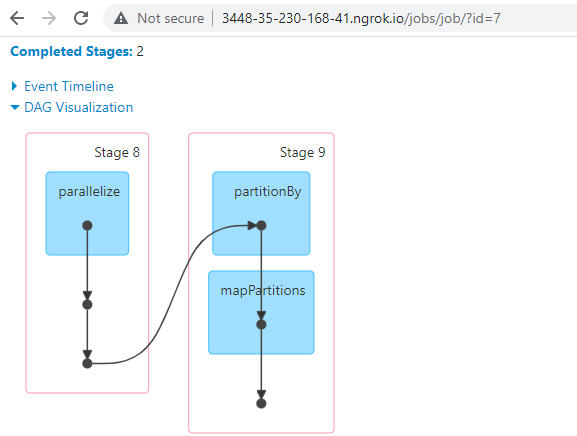